In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/calibration/10_01_24_ISLES_3D_LTS_HugeAugedRuns",
    # "/storage/vbutoi/scratch/ESE/calibration/10_02_24_ISLES_3D_SCTS_Big",
    # "/storage/vbutoi/scratch/ESE/calibration/10_02_24_ISLES_3D_SCTS_Small",
]

df_list_1 = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_1.append(df)
    except Exception as e:
        print(e)

df = pd.concat(df_list_1)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Subselect the df to only include lr that == 1.e-04
df = df[df['lr'] == 1.e-04]

In [4]:
df['lr'].unique()

array([0.0001])

In [5]:
def exp_name(path):
    exp_root = str(path).split("/")[-2]
    return exp_root

def aug_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_26_24_ISLES_3D_LTS_AllAug_v2_ElasticOnly":
        exp_n = "spatial"
    elif exp_root == "09_26_24_ISLES_3D_LTS_AllAugBackbone_v2":
        exp_n = "intensity + spatial"
    else:
        raise ValueError("Unknown experiment root")
    return exp_n

def norm_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_27_24_ISLES_3D_LTS_Bs6_lr1e-4_BATCHNORM":
        exp_n = "batch"
    elif exp_root == "09_27_24_ISLES_3D_LTS_Bs6_lr1e-4_LAYERNORM":
        exp_n = "layer"
    else:
        exp_n = "None"
    return exp_n

df.augment(exp_name)
# df.augment(aug_type)
df.augment(norm_type)

In [6]:
# we need to make batch_size and lr cateogorical variables
df['batch_size'] = df['batch_size'].astype('category')
df['lr'] = df['lr'].astype('category')

In [7]:
# We want to make sure that train goes before val in the phase
df['phase'] = df['phase'].astype('category')
df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)

<ipython-input-7-ee3f85ac4261>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)


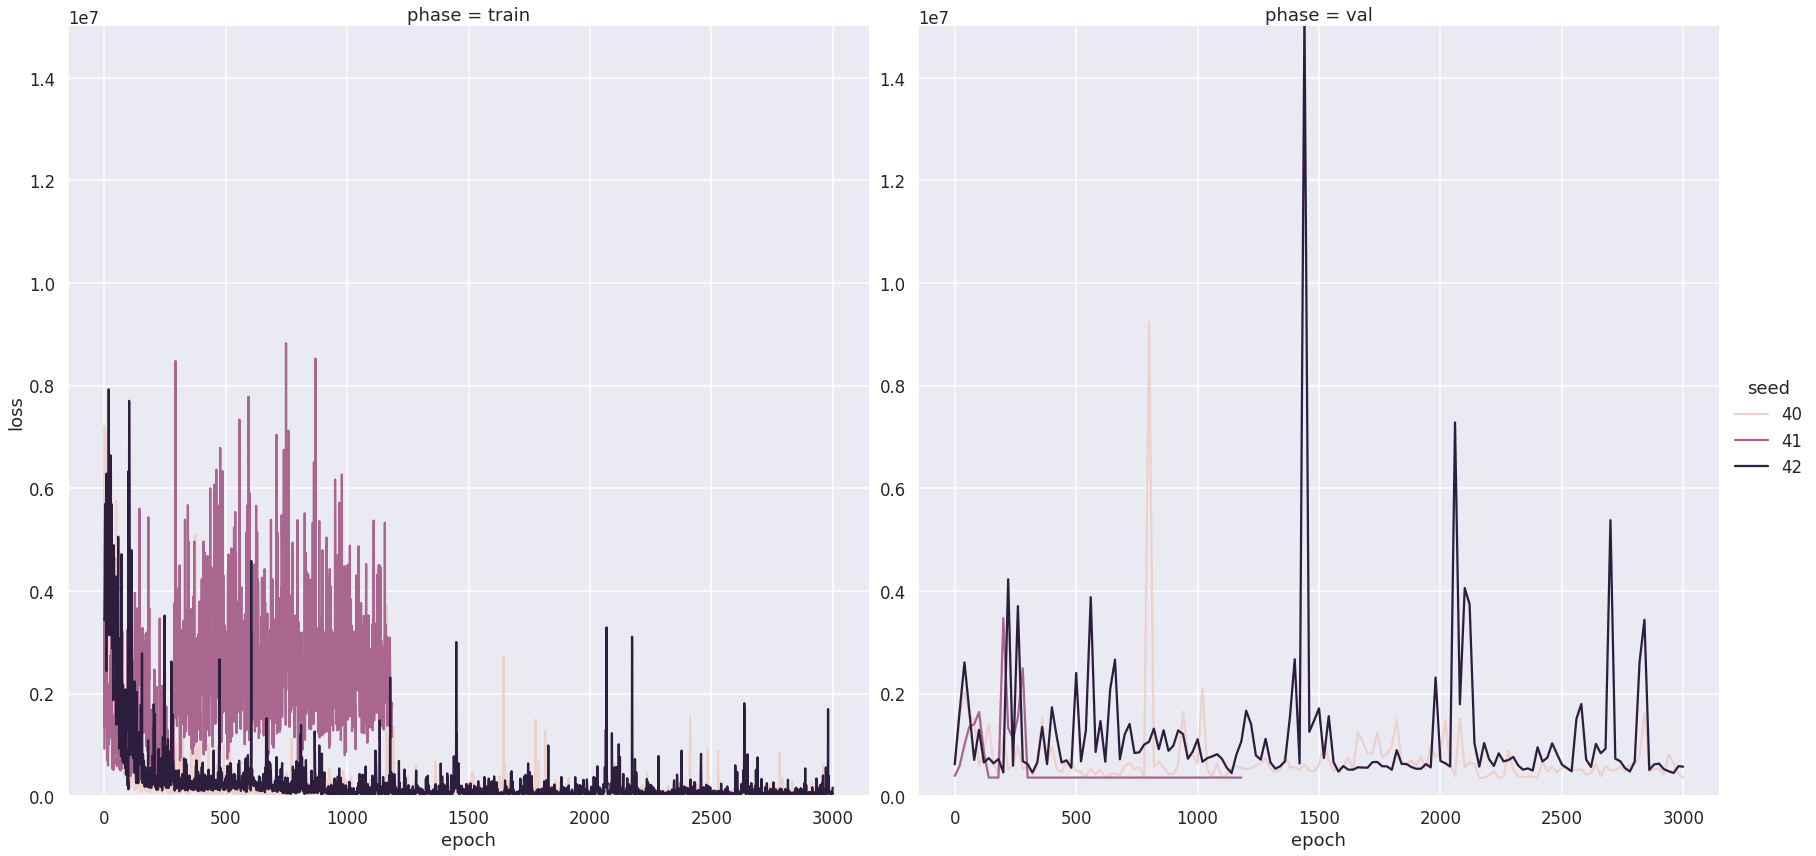

In [8]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    # hue='exp_name',
    hue='seed',
    # hue='loss_func',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacing
# g.fig.subplots_adjust(wspace=0.12)
g.set(ylim=(0, 15000000))

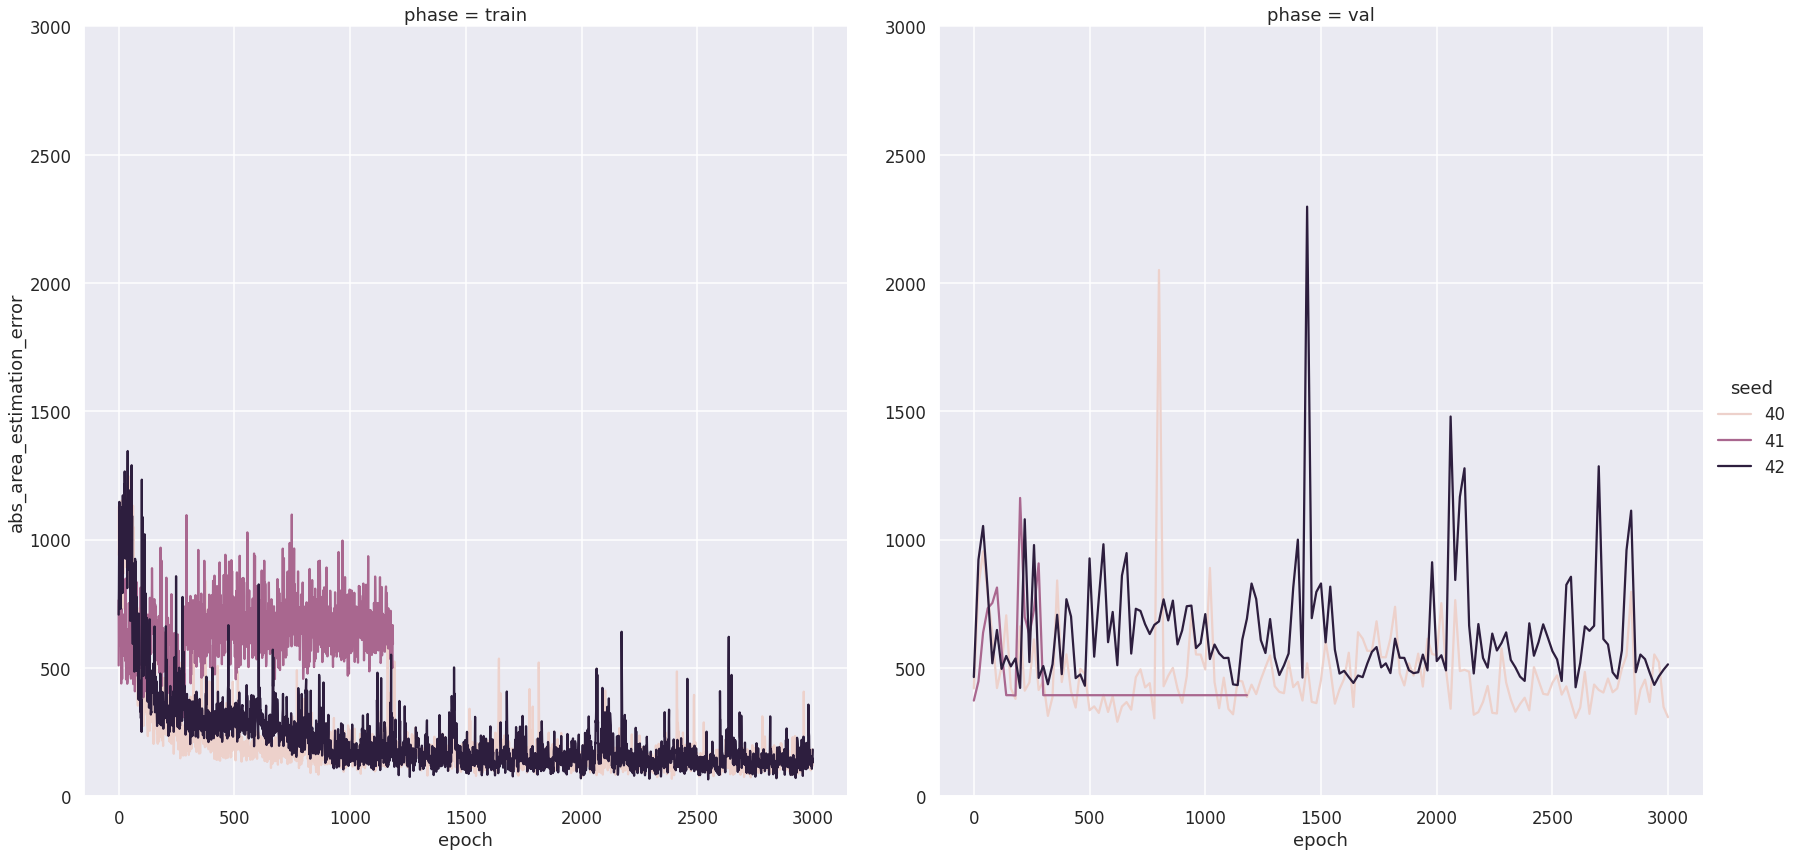

In [9]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='abs_area_estimation_error',
    # hue='exp_name',
    hue='seed',
    # hue='loss_func',
    col='phase',
    kind='line',
    height=12,
    facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)
# Set the y lim of the first subplot to be between 0 and 1500
g.set(ylim=(0, 3000))
# g.set(xlim=(0, 1300))

In [10]:
# g =  sns.relplot(
#     data=df,
#     x='epoch',
#     y='dice_score',
#     # hue='seed',
#     hue='aug_type',
#     col='phase',
#     kind='line',
#     height=12,
#     facet_kws=dict(sharey=False),
# )

# # Set column spacig
# g.fig.subplots_adjust(wspace=0.12)
# # g.set(ylim=(0.0, 0.25))